In [1]:
import os
import numpy as np
import bayesflow as bf
import pandas as pd
import pickle
import tensorflow as tf
import priors_and_simulators as ps
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Suppress scientific notation for floats
np.set_printoptions(suppress=True)

# Define settings
PATH = '/home/mischa/Documents/bayesflow/prj_real_life_ddm/git/data/prepared_data/'
PATH_TO_SAVE = '/home/mischa/Documents/bayesflow/prj_real_life_ddm/git/data/pickle_model_comparison/'

NUM_ITERATIONS_PER_EPOCH = 10000
BATCH_SIZE = 32
NUM_EPOCHS = 100

model_names = ["DDM", r"$DDM_{s\tau s\nu}$", "Levy", "GSR"]

simple_PARAM_NAMES = [
    r"$\nu_{congruent}$",
    r"$\nu_{incongruent}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",
    r"$\tau_{correct}$",
    r"$\tau_{error}$"
]

levy_PARAM_NAMES = [
    r"$\nu_{congruent}$",
    r"$\nu_{incongruent}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",
    r"$\tau_{correct}$",
    r"$\tau_{error}$",
    r"$\alpha$"
]


sv_st0_PARAM_NAMES = [
    r"$\nu_{congruent}$",
    r"$\nu_{incongruent}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",
    r"$\tau_{correct}$",
    r"$\tau_{error}$",
    r"$s_{\tau}$",
    r"$s_{\nu}$"
]

gsr_PARAM_NAMES = [
    r"$\gamma$",
    r"$\nu_{word}$",
    r"$\nu_{picture}$",
    r"$a_{congruent}$",
    r"$a_{incongruent}$",

    r"$\tau_{correct}$",
    r"$\tau_{error}$",
    r"$s_{\nu}$",
    r"$s_{\tau}"
]

2024-11-11 13:43:05.973544: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 13:43:05.996236: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 13:43:06.302390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mischa/miniconda3/envs/bf/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook imp

In [2]:
#Load prior functions, simulators

simple_ddm_prior = bf.simulation.Prior(prior_fun=ps.simple_ddm_prior_fun, param_names=simple_PARAM_NAMES)
levy_prior = bf.simulation.Prior(prior_fun=ps.levy_prior_fun, param_names=levy_PARAM_NAMES)
sv_st0_ddm_prior = bf.simulation.Prior(prior_fun=ps.sv_st0_ddm_prior_fun, param_names=sv_st0_PARAM_NAMES)
gsr_ddm_prior = bf.simulation.Prior(prior_fun=ps.gsr_ddm_prior_fun, param_names=gsr_PARAM_NAMES)

simple_ddm_simulator = bf.simulation.Simulator(simulator_fun=ps.simple_ddm_simulator_fun)
sv_st0_ddm_simulator = bf.simulation.Simulator(simulator_fun=ps.sv_st0_ddm_simulator_fun)
levy_simulator = bf.simulation.Simulator(simulator_fun=ps.levy_simulator_fun)
gsr_ddm_simulator = bf.simulation.Simulator(simulator_fun=ps.gsr_ddm_simulator_fun)

In [3]:
#Define generative models

model_simple_ddm = bf.simulation.GenerativeModel(
    prior=simple_ddm_prior,
    simulator=simple_ddm_simulator,
    name="simple_ddm")

model_sv_st0_ddm = bf.simulation.GenerativeModel(
    prior=sv_st0_ddm_prior,
    simulator=sv_st0_ddm_simulator,
    name="sv_st0_ddm")

model_levy= bf.simulation.GenerativeModel(
    prior=levy_prior,
    simulator=levy_simulator,
    name="levy")

model_gsr_ddm = bf.simulation.GenerativeModel(
    prior=gsr_ddm_prior,
    simulator=gsr_ddm_simulator,
    name="GSR_ddm")

generative_models = bf.simulation.MultiGenerativeModel([model_simple_ddm,
                                                        model_sv_st0_ddm,
                                                        model_levy,
                                                       model_gsr_ddm])
                                                          

INFO:root:Performing 2 pilot runs with the simple_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 120, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the sv_st0_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 120, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing 2 pilot runs with the levy mo

In [4]:
#Define networks, amortizer, trainer

summary_net = bf.summary_networks.SetTransformer(input_dim=4,summary_dim=20)

inference_net = bf.inference_networks.PMPNetwork(num_models=4, dropout=False)

amortizer = bf.amortizers.AmortizedModelComparison(inference_net, summary_net)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=generative_models,
    checkpoint_path = "model_comparison_checks"
)

2024-11-11 13:43:08.942479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-11 13:43:08.958808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-11 13:43:08.958912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Train model comparison network

In [7]:
def presimulator(x):
    file_list = [{} for _ in range(NUM_ITERATIONS_PER_EPOCH)]

    for k in range(NUM_ITERATIONS_PER_EPOCH):
        file_list[k] = generative_models(BATCH_SIZE)       
        
    with open('comparison_sims/presim_file_'+str(x)+'.pkl', 'wb+') as f:
        pickle.dump(file_list, f)
        
# Pre-simulate data for offline training (much faster due to parallel processing)        
if __name__ == '__main__':
    with Pool(processes=25) as pool:       
        pool.map(presimulator, range(NUM_EPOCHS))

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=
                                     tf.keras.optimizers.schedules.CosineDecay(
                                         1e-4, NUM_ITERATIONS_PER_EPOCH*NUM_EPOCHS, alpha=1e-8, name=None))
losses = trainer.train_from_presimulation('comparison_sims', optimizer = optimizer,
                                         reuse_optimizer=True)

Training epoch 1:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-17 12:17:37.994959: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9094100a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-17 12:17:37.994974: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-09-17 12:17:37.997840: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-17 12:17:38.005271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-09-17 12:17:38.074225: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training epoch 2:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/10000 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/10000 [00:00<?, ?it/s]

# Diagnostics

In [5]:
# Generate 10000 validation data sets
sim_data = generative_models(10000)

# Use the configurator to transform the data structure
sim_data_transformed = trainer.configurator(sim_data)

# Get true indices and predicted PMPs from the trained network
sim_indices = sim_data_transformed["model_indices"]
sim_preds = amortizer(sim_data_transformed)

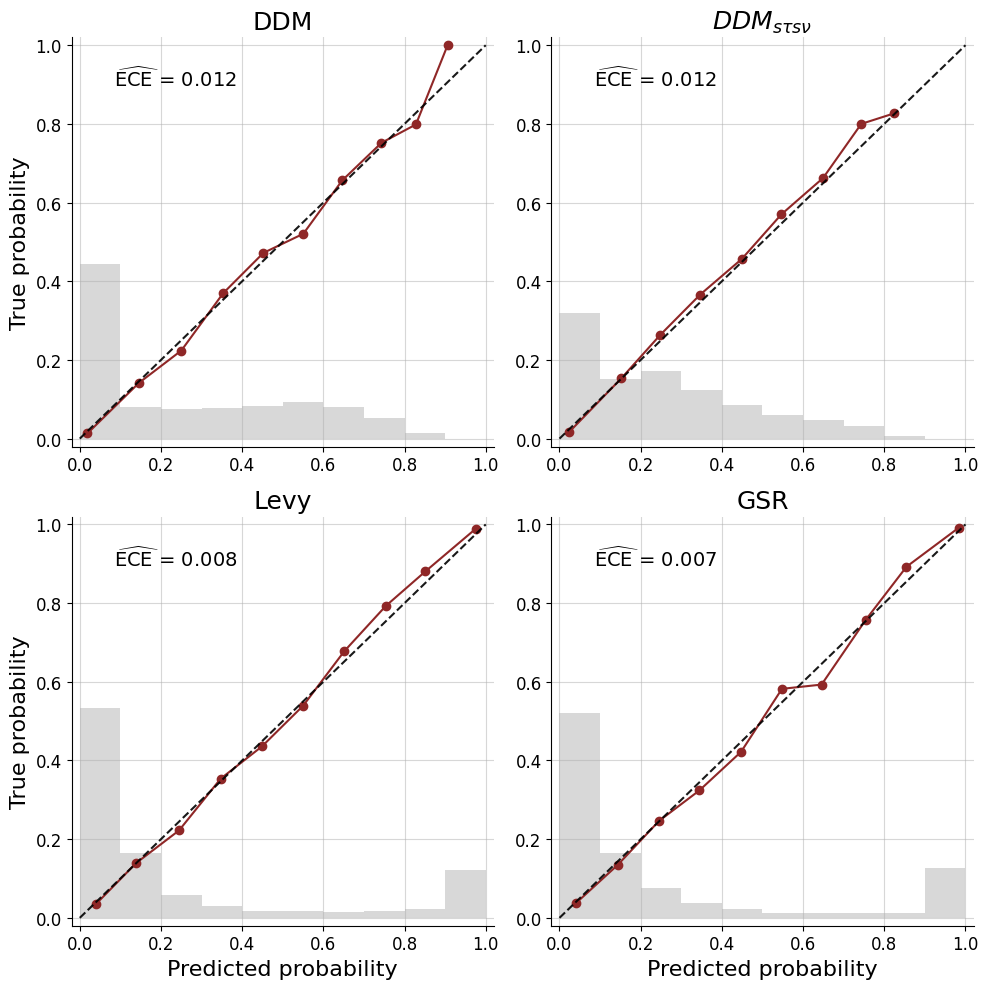

In [6]:
# Calibration plot
cal_curves = bf.diagnostics.plot_calibration_curves(true_models=sim_indices, pred_models=sim_preds,
                                                   model_names = model_names, n_row=2, n_col=2)

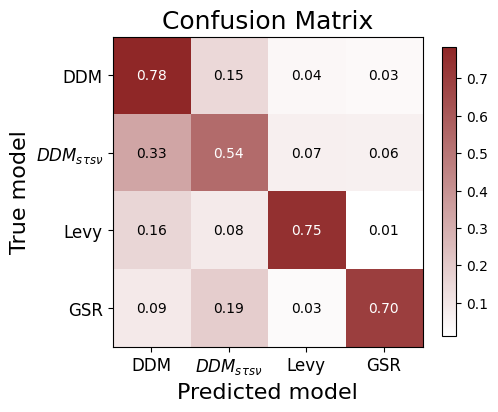

In [11]:
# Confusion matrix plot
conf_matrix = bf.diagnostics.plot_confusion_matrix(true_models=sim_indices, pred_models=sim_preds,
                                                   model_names = model_names)

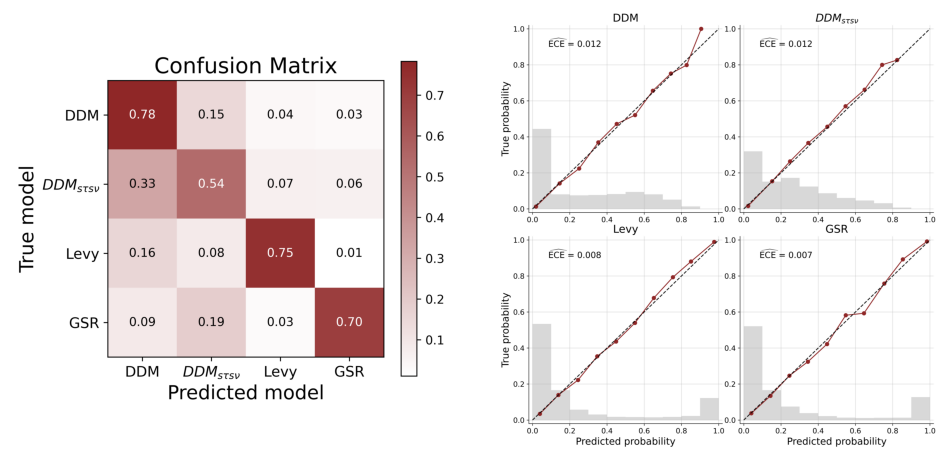

In [12]:
# Combined both plots for manuscript

from io import BytesIO
# Function to convert a figure to an image (with proper layout)
def figure_to_image(fig, dpi=600):
    # Adjust the layout to ensure nothing is cut off
    fig.tight_layout(pad=0.0)  # This adds extra space around the figure
    
    # Create a BytesIO buffer to hold the image data
    buf = BytesIO()

    # Save the figure to the buffer with tight bounding box and extra padding
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1, dpi=dpi)
    
    buf.seek(0)  # Reset the buffer position to the beginning
    
    # Read the image data from the buffer
    img = plt.imread(buf)
    return img

# Create the original figures
fig1 = conf_matrix
fig2 = cal_curves

# Convert the figures to images
img1 = figure_to_image(fig1)
img2 = figure_to_image(fig2)

# Create a new figure with subplots (1 row, 2 columns)
fig_combined, (ax_combined1, ax_combined2) = plt.subplots(1, 2, figsize=(12, 8))

# Display the images using imshow
ax_combined1.imshow(img1)
ax_combined2.imshow(img2)

# Hide the axes (we only want to show the images)
ax_combined1.axis('off')
ax_combined2.axis('off')

# Adjust layout to avoid clipping
fig_combined.subplots_adjust(wspace=0.1)

# Show the combined figure
plt.show()

# Apply model comparison to Project Implicit data

[0.05652964 0.32689817 0.24353999 0.3730322 ]prepared_False2003iat.p
[0.05814886 0.36015637 0.225927   0.35576777]prepared_False2004iat.p
[0.05879164 0.36838282 0.2211776  0.35164794]prepared_False2004iat2.p
[0.0608835  0.37577408 0.2156675  0.34767491]prepared_False2005iat.p
[0.06162061 0.38153219 0.21116025 0.34568695]prepared_False2005iat2.p
[0.06188356 0.38578496 0.20683462 0.34549686]prepared_False2005iat3.p
[0.06295463 0.38790117 0.20733691 0.34180729]prepared_False2005iat4.p
[0.06354957 0.38899688 0.20910492 0.33834862]prepared_False2005iat5.p
[0.06361691 0.38900811 0.20904173 0.33833325]prepared_False2005iat6.p
[0.06420855 0.38900314 0.20930713 0.33748118]prepared_False2006iat.p
[0.0644564  0.39061996 0.21053539 0.33438825]prepared_False2006iat2.p
[0.06439267 0.39215024 0.2113347  0.33212239]prepared_False2006iat3.p
[0.06448859 0.39378052 0.21249557 0.32923533]prepared_False2006iat4.p
[0.06500562 0.39522454 0.21238061 0.32738923]prepared_False2006iat5.p
[0.06577026 0.39788077 0

[0.06459291 0.40660109 0.21315244 0.31565356]prepared_False2018iat7.p
[0.06460084 0.40666515 0.21294844 0.31578557]prepared_False2018iat8.p
[0.06458687 0.40674528 0.21275303 0.31591482]prepared_False2018iat9.p
[0.06460558 0.40685048 0.21251864 0.3160253 ]prepared_False2019iat.p
[0.06458551 0.40695834 0.21228513 0.31617103]prepared_False2019iat10.p
[0.06456712 0.40709019 0.21207228 0.31627041]prepared_False2019iat11.p
[0.06453926 0.40721979 0.21185084 0.31639012]prepared_False2019iat12.p
[0.06451809 0.40731799 0.2116533  0.31651062]prepared_False2019iat13.p
[0.06452076 0.4073991  0.21145931 0.31662082]prepared_False2019iat2.p
[0.06450748 0.40747721 0.21126489 0.31675042]prepared_False2019iat3.p
[0.06450248 0.40759287 0.21108039 0.31682426]prepared_False2019iat4.p
[0.06448767 0.40769119 0.210892   0.31692914]prepared_False2019iat5.p
[0.06449705 0.40778886 0.21060588 0.31710821]prepared_False2019iat6.p
[0.06453261 0.40788345 0.21031015 0.31727379]prepared_False2019iat7.p
[0.06455364 0.407

[0.0649369  0.41318072 0.19636852 0.32551386]prepared_True2017iat9.p
[0.0649492  0.41316424 0.19629212 0.32559444]prepared_True2018iat.p
[0.06494691 0.41317368 0.19620736 0.32567205]prepared_True2018iat10.p
[0.06494586 0.41318626 0.19612365 0.32574423]prepared_True2018iat11.p
[0.06494017 0.41319454 0.19606126 0.32580403]prepared_True2018iat12.p
[0.06494473 0.41319564 0.19602821 0.32583142]prepared_True2018iat13.p
[0.0649429  0.41318979 0.19597018 0.32589713]prepared_True2018iat2.p
[0.06494442 0.41318815 0.19589742 0.32597002]prepared_True2018iat3.p
[0.06494627 0.41317849 0.19584204 0.3260332 ]prepared_True2018iat4.p
[0.06495015 0.41317644 0.195771   0.32610241]prepared_True2018iat5.p
[0.06496889 0.41319369 0.19565209 0.32618532]prepared_True2018iat6.p
[0.06499753 0.41318944 0.19553773 0.3262753 ]prepared_True2018iat7.p
[0.06501341 0.41318214 0.19547255 0.3263319 ]prepared_True2018iat8.p
[0.06501331 0.41319066 0.19541344 0.32638259]prepared_True2018iat9.p
[0.06502828 0.41321025 0.195309

KeyError: "None of [Index(['0', '1', '2', '3'], dtype='object')] are in the [columns]"

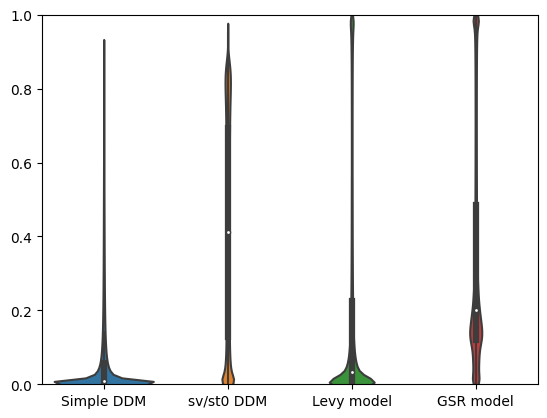

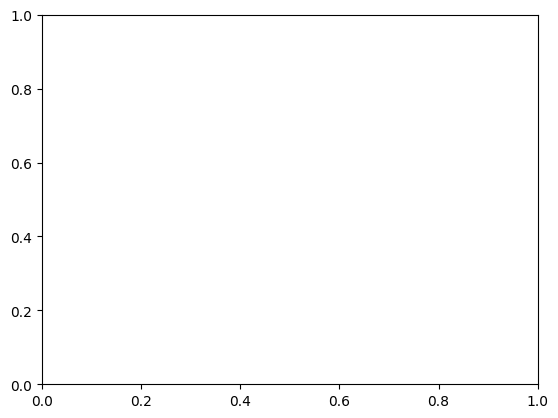

In [16]:
# 1. Create list of all data subsets/chunks, initialize np.array to be filled during inference

datasets = sorted(os.listdir(PATH))

all_probs_and_ids = np.empty((1,6))

# 2. For each chunk

   
for dataset_name in datasets:
    
        # 2.1 Load chunk
        loaded_pickle = pickle.load(open(PATH +str(dataset_name), "rb" ))
        
        X_test = loaded_pickle['data_array']
        y_test = loaded_pickle['outcome_array']

        # 2.2 Estimate chunk
        
        model_probs = np.concatenate([
            amortizer.posterior_probs({"summary_conditions": x}) for x in np.array_split(X_test, 50)], axis=0)
        
        probs_and_ids = np.concatenate([model_probs, y_test], axis=1)  
        
        all_probs_and_ids =  np.concatenate([all_probs_and_ids, probs_and_ids], axis=0)

        print(str(np.mean(all_probs_and_ids[1:,0:4] ,axis=0)) + str(dataset_name))
               
# 3. Save all model probabilites in csv and create figures

df = pd.DataFrame(all_probs_and_ids[1:,:])

df.to_csv("all_model_probabilites.csv")

ax = sns.violinplot(data=all_probs_and_ids[1:,0:4])
ax.set_xticklabels(['Simple DDM','sv/st0 DDM', 'Levy model', 'GSR model'])
ax.set(ylim=(0, 1))
fig = ax.get_figure()
fig.savefig('model_probs.png')    

df = pd.read_csv("all_model_probabilites.csv")

fig, ax = plt.subplots()
sns.pointplot(df[["0", "1", "2", "3"]], estimator = np.mean, errorbar=("pi", 90))
ax.set_xticklabels(['Simple DDM','sv/st0 DDM', 'Levy model', 'GSR model'])
ax.set_ylim(0, 1)
fig = ax.get_figure()
fig.savefig('model_probs2.png')  

In [10]:
# Simple DDM is best for this number of people:

np.sum((df["0"]>df["1"])& (df["0"]>df["2"])& (df["0"]>df["3"]))

262362

In [11]:
# st0/sv DDM is best for this number of people:

np.sum((df["1"]>df["0"])& (df["1"]>df["2"])& (df["1"]>df["3"]))

2764901

In [12]:
# Levy model is best for this number of people:

np.sum((df["2"]>df["0"])& (df["2"]>df["1"])& (df["2"]>df["3"]))

1036646

In [14]:
# GSR model is best for this number of people:

np.sum((df["3"]>df["0"])& (df["3"]>df["1"])& (df["3"]>df["2"]))

1512229